## quant-econ Solutions: Discrete Dynamic Programming

Solutions for http://quant-econ.net/py/discrete_dp.html

Prepared by **Daisuke Oyama**, Faculty of Economics, University of Tokyo

The exercise is to replicate numerically the analytical solution for the benchmark model in  [this lecture](http://quant-econ.net/py/dp_intro.html) of quant-econ, using the `DiscreteDP` class.  

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from quantecon.markov import DiscreteDP

## Setup

Consider the following problem:
$$
\begin{aligned}
&\max_{\{c_t\}_{t=0}^{\infty}} \sum_{t=0}^{\infty} \beta^t u(c_t) \\\\
&\ \text{ s.t. }\ k_{t+1} = f(k_t) - c_t,
 \quad \text{$k_0$: given},
\end{aligned}
$$
where
$k_t$ and $c_t$ are the capital stock and consumption at time $t$, respectively,
$u$ is the utility function,
$f$ is the production function, and
$\beta \in (0, 1)$ is the discount factor.

We let $f(k) = k^{\alpha}$ with $\alpha = 0.65$, $u(c) = \log c$, and $\beta = 0.95$.

In [3]:
alpha = 0.65
f = lambda k: k**alpha
u = np.log
beta = 0.95

We discretize the state space into a grid of size `grid_size=1500`,
from $10^{-6}$ to `grid_max=2`.

In [4]:
grid_max = 2
grid_size = 1500
grid = np.linspace(1e-6, grid_max, grid_size)

In [5]:
print(grid)

[  1.00000000e-06   1.33522215e-03   2.66944430e-03 ...,   1.99733156e+00
   1.99866578e+00   2.00000000e+00]


We choose the action to be the amount of capital to save for the next period
(the state is the capical stock at the beginning of the period).
Thus the state indices and the action indices are both `0`, ..., `grid_size-1`.
Action (indexed by) `a` is feasible at state (indexed by) `s` if and only if
`grid[a] < f([grid[s])`
(zero consumption is not allowed).

The transition probability array `Q` will be highly sparse
(in fact it is degenerate as the model is deterministic),
so we formulate the problem with state-action pairs, to represent `Q` in sparse matrix format.

We first construct indices for state-action pairs:

In [6]:
# Consumption matrix, with nonpositive consumption included
C = f(grid).reshape(grid_size, 1) - grid.reshape(1, grid_size)

# State-action indices
s_indices, a_indices = np.where(C > 0)

# Number of state-action pairs
L = len(s_indices)

In [7]:
print(L)
print(s_indices)
print(a_indices)

1069790
[   0    1    1 ..., 1499 1499 1499]
[   0    0    1 ..., 1174 1175 1176]


Reward vector `R` (of length `L`):

In [8]:
R = u(C[s_indices, a_indices])

(Degenerate) transition probability matrix `Q` (of shape `(L, grid_size)`):

In [9]:
Q = sparse.lil_matrix((L, grid_size))
Q[np.arange(L), a_indices] = 1

Discrete growth model:

In [10]:
dgm = DiscreteDP(R, Q, beta, s_indices, a_indices)

## Solving the model

Solve the dynamic optimization problem:

In [11]:
res = dgm.solve(method='policy_iteration')
v, sigma, num_iter = res.v, res.sigma, res.num_iter

In [12]:
num_iter

14

In [13]:
# Optimal consumption in the discrete version
c = f(grid) - grid[sigma]

In [14]:
# Exact solution of the continuous version
ab = alpha * beta
c1 = (np.log(1 - ab) + np.log(ab) * ab / (1 - ab)) / (1 - beta)
c2 = alpha / (1 - ab)
def v_star(k):
    return c1 + c2 * np.log(k)

def c_star(k):
    return (1 - ab) * k**alpha

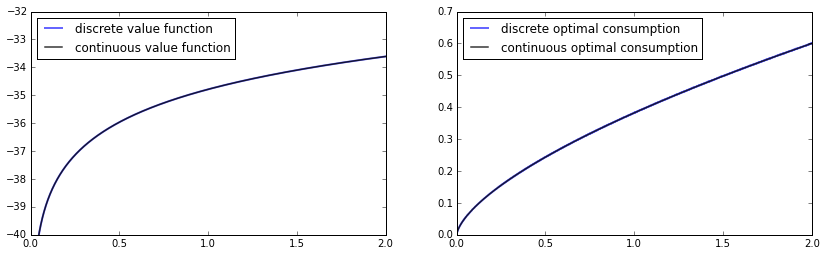

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].set_ylim(-40, -32)
ax[0].set_xlim(grid[0], grid[-1])
ax[1].set_xlim(grid[0], grid[-1])

lb0 = 'discrete value function'
ax[0].plot(grid, v, lw=2, alpha=0.6, label=lb0)

lb0 = 'continuous value function'
ax[0].plot(grid, v_star(grid), 'k-', lw=1.5, alpha=0.8, label=lb0)
ax[0].legend(loc='upper left')

lb1 = 'discrete optimal consumption'
ax[1].plot(grid, c, 'b-', lw=2, alpha=0.6, label=lb1)

lb1 = 'continuous optimal consumption'
ax[1].plot(grid, c_star(grid), 'k-', lw=1.5, alpha=0.8, label=lb1)
ax[1].legend(loc='upper left')
plt.show()

The outcomes appear very close to those of the continuous version.

Except for the "boundary" point, the value functions are very close:

In [16]:
np.abs(v - v_star(grid)).max()

121.49819147053378

In [17]:
np.abs(v - v_star(grid))[1:].max()

0.0038595076780651993

The optimal consumption functions are close as well:

In [18]:
np.abs(c - c_star(grid)).max()

0.0013020872868430011

In fact, the optimal consumption obtained in the discrete version is not really monotone,
but the decrements are quit small:

In [19]:
diff = np.diff(c)
(diff >= 0).all()

False

In [20]:
dec_ind = np.where(diff < 0)[0]

In [21]:
len(dec_ind)

521

In [22]:
np.abs(diff[dec_ind]).max()

0.00065355751082307734

The value function is monotone:

In [23]:
(np.diff(v) > 0).all()

True

## Comparison of the solution methods

### Value iteration

In [24]:
dgm.epsilon = 1e-4
dgm.max_iter = 500
res1 = dgm.solve(method='value_iteration')

In [25]:
res1.num_iter

294

In [26]:
np.array_equal(sigma, res1.sigma)

True

### Modified policy iteration

In [27]:
res2 = dgm.solve(method='modified_policy_iteration')

In [28]:
res2.num_iter

16

In [29]:
np.array_equal(sigma, res2.sigma)

True

### Speed comparison

In [30]:
%timeit dgm.solve(method='value_iteration')
%timeit dgm.solve(method='policy_iteration')
%timeit dgm.solve(method='modified_policy_iteration')

1 loops, best of 3: 7.2 s per loop
1 loops, best of 3: 467 ms per loop
1 loops, best of 3: 488 ms per loop


## Dynamics of the capital stock

Let us work on [Exercise 2](http://quant-econ.net/py/dp_intro.html#exercise-2),
where we plot the trajectories of the capital stock for three different discount factors,
$0.9$, $0.94$, and $0.98$, with initial condition $k_0 = 0.1$.

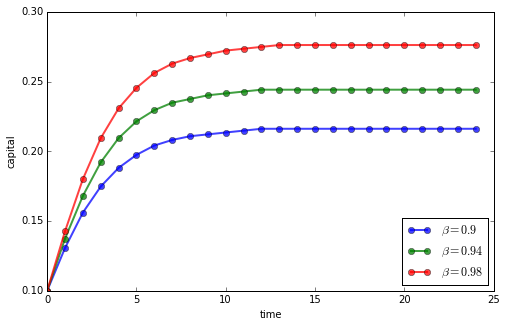

In [33]:
discount_factors = (0.9, 0.94, 0.98)
k_init = 0.1

# Search for the index corresponding to k_init
k_init_ind = np.searchsorted(grid, k_init)

sample_size = 25

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel("time")
ax.set_ylabel("capital")
ax.set_ylim(0.10, 0.30)

for beta in discount_factors:
    dgm.beta = beta
    res = dgm.solve()
    k_sim_ind = res.mc.simulate(init=k_init_ind, ts_length=sample_size)
    k_sim = grid[k_sim_ind]
    ax.plot(k_sim, 'o-', lw=2, alpha=0.75, label=r'$\beta = {}$'.format(beta))

ax.legend(loc='lower right')
plt.show()